In [1]:
import sys 
sys.path.append('../src') 
import numpy as np
#for some reason, matplotlib crashes without these lines
a = np.zeros((5,5))
a@a
import matplotlib.pyplot as plt
import Autoencoder
# from torchsummary import summary
# from Autoencoder import Autoencoder
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from utils import calc_energy, torch2np, np2torch
import glob
import os
import time
# from importlib import reload

device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)
    

In [2]:
def kernel(X:torch.Tensor, Y, theta, dx = 0.0125, dy = None):
    """
    Compute the total energy of a visco-elastic flow

    Parameters
    ----------
    X : array_like
        Simulation data
    Wi, beta, Re : float
                    Simulation paramters
    dx : float
        uniform mesh spacing

    Returns
    -------
    elastic : array
            The elastic energy on each snapshot of the input
    kinetic : array
            The kinect energy on each snapshot of the input
    total_energy: array
            The total energy on each snapshot of the input
    """
    if dy is None:
        dy = dx
    area = dx*dy * 0.5
    c = torch.ones((X.shape[0],5),device = X.device)
    c[:,2:] *= theta
    c[:,3] *= 2
    total_energy = torch.einsum('ijk, njk, ij -> in',X,Y,c)
    return torch.diag(total_energy) * area
def energy_loss(x,y,param, dx = 1/2**6):
    Wi = param[:,0].view((-1,1))
    beta= param[:,1].view((-1,1))
    theta = (1- beta) / Wi
    Kxx = kernel(x,x, theta, dx, dx)
    Kxy = kernel(x,y, theta, dx, dx)
    Kyy = kernel(y,y, theta, dx, dx)

    loss = torch.sqrt(Kxx - 2* Kxy + Kyy)
    
    return loss.mean()

In [3]:
def get_matrix(filename, ndata = 3000):
    #reads the file
    filename_no_ext = ".".join(filename.split('.')[:-1])
    f_split = filename_no_ext.split('_')
    Re = float(f_split[2].replace('Re',''))
    Wi = float(f_split[3].replace('Wi',''))
    beta = float(f_split[4].replace('beta',''))
    fields = np.load(f'{dspath}/{filename}', allow_pickle=True)["fields"].item()
    #Extract the fields
    u = fields["vel-u"]
    v = fields["vel-v"]
    Bxx = fields["Bxx"]
    Bxy = fields["Bxy"]
    Byy = fields["Byy"]
    q = np.stack((u,v,Bxx, Bxy, Byy), axis=-1)


    # reshape for the expected code format
    TU = q[:,:,:,0].reshape((q.shape[0]**2, q.shape[2]))
    TV = q[:,:,:,1].reshape((q.shape[0]**2, q.shape[2]))
    T11 = q[:,:,:,2].reshape((q.shape[0]**2, q.shape[2]))
    T12 = q[:,:,:,3].reshape((q.shape[0]**2, q.shape[2]))
    T22 = q[:,:,:,4].reshape((q.shape[0]**2, q.shape[2]))
    T = np.concatenate((TU, TV, T11,T12,T22), axis=1).reshape(-1, q.shape[2]) # by column axis=1(intercal..), by row axis=0
    X =  T[:, -ndata:]
    param =  np.repeat((Re,Wi,beta), X.shape[1]).reshape((3,-1)).T
    theta_sqrt = np.sqrt((1-param[:,2])/(param[:,0] * param[:,1])).reshape((-1,1))
    return X.T, theta_sqrt, (Re, Wi, beta)

In [4]:
# dspath = '/home/fabio/npz_data/KPCA_4roll' # Four roll
dspath = '../../npz_data/KPCA_4roll_osc' # cavity

files = glob.glob('*.npz', root_dir=dspath)
for f in files:
    print(f)
ntimes = 1000
n_data = ntimes * len(files)
X, sqrt_theta, param = get_matrix(files[3], ntimes)

4_roll7vtk_Re1_Wi3.5_beta0.9_dataset.npz
4_roll7vtk_Re1_Wi3.8_beta0.9_dataset.npz
4_roll7vtk_Re1_Wi3_beta0.9_dataset.npz
4_roll7vtk_Re1_Wi4_beta0.9_dataset.npz


In [5]:
Re = param[0]
Wi = param[1]
beta = param[2]
theta_mult = sqrt_theta @ sqrt_theta.T
theta = np.diag(theta_mult)[:,None]
dx = dy = (np.pi)/32
_, _, energy_X = calc_energy(X.T,Wi,beta, Re, dx, dy)
print(f'Theta: {theta[0]}')

Theta: [0.025]


In [6]:
X_torch = np2torch(X.T).float()
train_dataset = TensorDataset(X_torch)
train_loader = DataLoader(train_dataset, batch_size=1000)
num_batches = len(train_loader)

In [7]:
loss_energy = 'ENERGY'
mse_loss = torch.nn.MSELoss()
if loss_energy == 'ENERGY':
        def loss_fn(input:torch.Tensor, target:torch.Tensor, mu:torch.Tensor, log_var:torch.Tensor, param:torch.tensor, kld_weight = 0.0025):
                # reconst_loss = torch.nn.MSELoss()(input, target)
                reconst_loss = energy_loss(input, target, param)
                kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
                # kld_weight = 0.0025
                return reconst_loss, kld_loss*kld_weight
elif loss_energy == 'MSE':
        def loss_fn(input:torch.Tensor, target:torch.Tensor, mu:torch.Tensor, log_var:torch.Tensor, param:torch.tensor = None, kld_weight = 0.0025):
                reconst_loss = mse_loss(input, target)
                # reconst_loss = energy_loss(input, target, param)
                kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
                # kld_weight = 0.0025
                return reconst_loss, kld_loss*kld_weight
elif loss_energy == 'BOTH':
        def loss_fn(input:torch.Tensor, target:torch.Tensor, mu:torch.Tensor, log_var:torch.Tensor, param:torch.tensor, kld_weight = 0.0025):
                # reconst_loss = torch.nn.MSELoss()(input, target)
                reconst_loss = energy_loss(input, target, param) + mse_loss(input, target)
                kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
                # kld_weight = 0.0025
                return reconst_loss, kld_loss*kld_weight
else:
        raise Exception("Invalid loss function. Values are ['ENERGY', 'MSE', 'BOTH']")

In [8]:
min_in = X_torch.amin(dim=2).amin(0).reshape((1,5,1)).float()
max_in = X_torch.amax(dim=2).amax(0).reshape((1,5,1)).float()

latent_dim = 3

In [96]:
num_epochs = 5000
autoencoder = Autoencoder.VariationalAutoencoderModule(X_torch.shape[-1], latent_dim, max_in, min_in).to(device)

learning_rate = 1e-4
kl_weight = 1e-3
optimizer = torch.optim.Adam(autoencoder.parameters(),lr = learning_rate)
pasta = f'../ModelsTorch/VAE_FR-NonParam_Latent_{latent_dim}_energy_{loss_energy}_beta_{kl_weight}'
os.makedirs(pasta, exist_ok=True)

In [97]:
# Early stop
best_vloss = 1_000_000
last_loss = best_vloss
patience = 0
param  = torch.tensor([[Wi, beta]]).float().to(device)

for e in range(num_epochs):
    if last_loss < best_vloss:
                    best_vloss = last_loss
                    torch.save({'optimizer_state_dict':optimizer.state_dict(), 'loss':loss, 'epoch':e}, f'{pasta}/optimizer_checkpoint.pt')
                    torch.save(autoencoder.state_dict(), f'{pasta}/best_autoencoder')
                    patience = 0
    else:
            patience +=1

    if patience > 100:
        autoencoder.load_state_dict(torch.load( f'{pasta}/best_autoencoder'))
        break

    cumm_loss = 0
    cumm_loss_rec = 0
    cumm_loss_kld = 0
    cumm_loss_pred = 0
    t = time.time()
    autoencoder.train(True)
    for data_list in train_loader:
        data = data_list[0]
        optimizer.zero_grad()
        # Use the context manager
        # with ClearCache():
        data = data.to(device)
        
        code, mu, log_var = autoencoder.encode(data)
        reconst = autoencoder.decode(code)
        reconst_loss, kdl_loss = loss_fn(data, reconst, mu, log_var, param, kl_weight)

        loss = reconst_loss + kdl_loss 
        loss.backward()
        optimizer.step()

        cumm_loss += loss.item()
        cumm_loss_rec += reconst_loss.item()
        cumm_loss_kld += kdl_loss.item()
    t = time.time() - t
    last_loss = cumm_loss
    with torch.no_grad():
        autoencoder.eval()
        for X_test in train_loader:
            X_test = X_test[0].to(device)

            code, mu, log_var = autoencoder.encode(X_test)
            reconst = autoencoder.decode(code)
            loss_rec_test, loss_kld_test = loss_fn(X_test, reconst,mu, log_var, param, kl_weight)
            loss_test = loss_rec_test + loss_kld_test
    print(f'Epoch {e}: train loss: {cumm_loss:.4f}\ttest loss: {loss_test.item():.4f}\tExec. Time of epoch: {t:.3f}s({t/num_batches:.3f}s/batch)', flush=True)
    print(f'Reconst loss train: {cumm_loss_rec:.4f}, KLD loss train: {cumm_loss_kld:.4f}', flush=True)
    print(f'Reconst loss test: {loss_rec_test.item():.4f}, KLD loss test: {loss_kld_test.item():.4f}', flush=True)
    print(flush=True)

print('\n\n')

Epoch 0: train loss: 2.2311	test loss: 2.1774	Exec. Time of epoch: 0.334s(0.334s/batch)
Reconst loss train: 2.2311, KLD loss train: 0.0000
Reconst loss test: 2.1774, KLD loss test: 0.0000

Epoch 1: train loss: 2.1775	test loss: 2.1150	Exec. Time of epoch: 0.257s(0.257s/batch)
Reconst loss train: 2.1775, KLD loss train: 0.0000
Reconst loss test: 2.1150, KLD loss test: 0.0000

Epoch 2: train loss: 2.1148	test loss: 2.0321	Exec. Time of epoch: 0.248s(0.248s/batch)
Reconst loss train: 2.1148, KLD loss train: 0.0000
Reconst loss test: 2.0321, KLD loss test: 0.0000

Epoch 3: train loss: 2.0320	test loss: 1.9245	Exec. Time of epoch: 0.252s(0.252s/batch)
Reconst loss train: 2.0320, KLD loss train: 0.0000
Reconst loss test: 1.9245, KLD loss test: 0.0000

Epoch 4: train loss: 1.9268	test loss: 1.7917	Exec. Time of epoch: 0.262s(0.262s/batch)
Reconst loss train: 1.9268, KLD loss train: 0.0000
Reconst loss test: 1.7917, KLD loss test: 0.0000

Epoch 5: train loss: 1.7908	test loss: 1.6321	Exec. Tim

C:\Users\Administrador\AppData\Local\Temp\ipykernel_1684\3251636978.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load( f'{pasta}/be

In [98]:
energies = []
mses = []


norm_mse = np.linalg.norm(X)
sum_energy = X.sum()
X_rec,_,_ = autoencoder(X_torch.to(device))
X_rec = torch2np(X_rec)
# 4- Calc error
_, _, energy_rec = calc_energy(X_rec,Wi,beta, Re, dx, dy)
energies.append(energy_rec)
mses.append(np.linalg.norm(X - X_rec.T) / norm_mse)

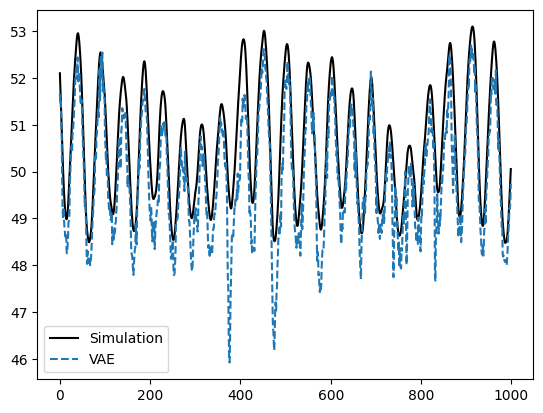

In [99]:
plt.plot(energy_X,'k', label = 'Simulation')
for e in energies:
    # if k == 'oldroyd':
    #     plt.plot(e,'--', label = k)
    plt.plot(e,'--', label = 'VAE')
plt.legend()

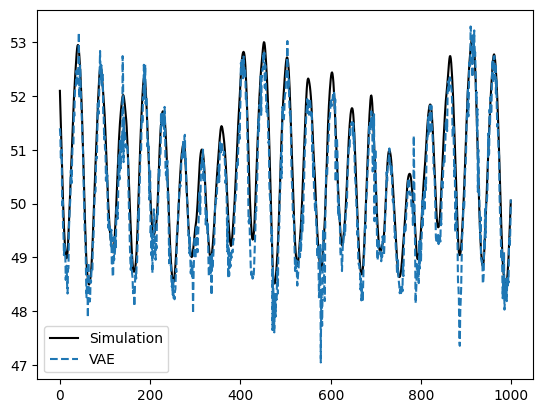

In [93]:
plt.plot(energy_X,'k', label = 'Simulation')
for e in energies:
    # if k == 'oldroyd':
    #     plt.plot(e,'--', label = k)
    plt.plot(e,'--', label = 'VAE')
plt.legend()

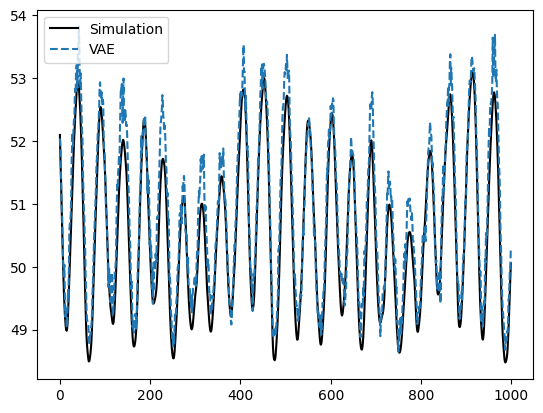

In [87]:
plt.plot(energy_X,'k', label = 'Simulation')
for e in energies:
    # if k == 'oldroyd':
    #     plt.plot(e,'--', label = k)
    plt.plot(e,'--', label = 'VAE')
plt.legend()

# Tests

In [4]:
def get_tra(X):
    bxx = X[2::5]
    byy = X[4::5]

    Tra = bxx + byy
    return Tra

In [31]:
selected_file = files[12]
simulation_name  = ".".join(selected_file.split('.')[:-1])
X, sqrt_theta, param = get_matrix(selected_file, 0)

In [32]:
Re = param[0]
Wi = param[1]
beta = param[2]
dx = dy = (np.pi)/64
_, _, energy_X_train = calc_energy(X.T,Wi,beta, Re, dx, dy)
Tra = get_tra(X.T)
Tra = Tra.reshape((64,64,-1))

Text(0.5, 1.0, 'Tr(B)')

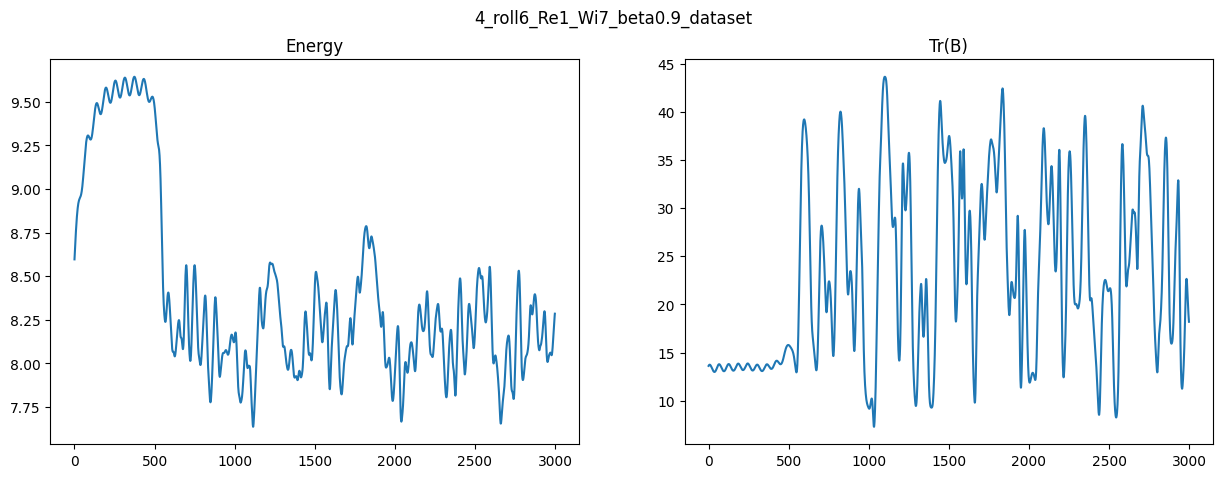

In [33]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle(simulation_name)

ax[0].plot(energy_X_train[200:3200])
ax[0].set_title('Energy')

ax[1].plot(Tra[32,32, 200:3200])
ax[1].set_title('Tr(B)')

In [5]:
# dspath = '/home/fabio/npz_data/KPCA_4roll' # Four roll
dspath = '../../npz_data/KPCA_4roll' # cavity
# dspath = '../../npz_data/KPCA_4roll_osc' # cavity
# dspath = '../../npz_data/KPCA_4roll_osc6' # cavity

files = glob.glob('*.npz', root_dir=dspath)
for i,f in enumerate(files):
    print(i, f)
# ntimes = 2000
# n_data = ntimes * len(files)

# selected_file = files[3]
# simulation_name  = ".".join(selected_file.split('.')[:-1])
# X, sqrt_theta, param = get_matrix(selected_file, ntimes)

0 16_roll7vtk_Re1_Wi3.5_beta0.9.npz
1 4_roll6_Re1_Wi5.5_beta0.3_dataset.npz
2 4_roll6_Re1_Wi5.5_beta0.6_dataset.npz
3 4_roll6_Re1_Wi5.5_beta0.9_dataset.npz
4 4_roll6_Re1_Wi6.5_beta0.3_dataset.npz
5 4_roll6_Re1_Wi6.5_beta0.6_dataset.npz
6 4_roll6_Re1_Wi6.5_beta0.9_dataset.npz
7 4_roll6_Re1_Wi6_beta0.3_dataset.npz
8 4_roll6_Re1_Wi6_beta0.6_dataset.npz
9 4_roll6_Re1_Wi6_beta0.9_dataset.npz
10 4_roll6_Re1_Wi7_beta0.3_dataset.npz
11 4_roll6_Re1_Wi7_beta0.6_dataset.npz
12 4_roll6_Re1_Wi7_beta0.9_dataset.npz
13 4_roll7vtk_Re1_Wi4_beta0.9.npz


In [27]:
selected_file = files[9]
simulation_name  = ".".join(selected_file.split('.')[:-1])
print(simulation_name)
X, sqrt_theta, param = get_matrix(selected_file, 0)

X_train = X[200:3200]
X_test = X[3200:]

Re = param[0]
Wi = param[1]
beta = param[2]
theta_mult = sqrt_theta @ sqrt_theta.T
theta = np.diag(theta_mult)[:,None]
dx = dy = (np.pi)/64
_, _, energy_X_train = calc_energy(X_train.T,Wi,beta, Re, dx, dy)
_, _, energy_X_test = calc_energy(X_test.T,Wi,beta, Re, dx, dy)
print(f'Theta: {theta[0]}')
X_train_torch = np2torch(X_train.T).float()
X_test_torch = np2torch(X_test.T).float()

min_in = X_train_torch.amin(dim=2).amin(0).reshape((1,5,1)).float()
max_in = X_train_torch.amax(dim=2).amax(0).reshape((1,5,1)).float()
latent_dim = 3

ae_mse = Autoencoder.VariationalAutoencoderModule(X_train_torch.shape[-1], latent_dim, max_in, min_in).to(device)
ae_both = Autoencoder.VariationalAutoencoderModule(X_train_torch.shape[-1], latent_dim, max_in, min_in).to(device)

ae_mse.load_state_dict(torch.load(f'../ModelsTorch/VAE_Latent_{latent_dim}_energy_MSE_{simulation_name}/best_autoencoder',map_location=device, weights_only=True))
ae_both.load_state_dict(torch.load(f'../ModelsTorch/VAE_Latent_{latent_dim}_energy_BOTH_{simulation_name}/best_autoencoder',map_location=device, weights_only=True))


ae_mse.eval()
ae_both.eval()
print()


4_roll6_Re1_Wi6_beta0.9_dataset
Theta: [0.01666667]



In [28]:

labels = ['MSE', 'BOTH']

energies = []
mses = []
err_energy = []
norm_mse = np.linalg.norm(X_train)
sum_energy = energy_X_train.sum()
for ae in [ae_mse, ae_both]:
    X_rec,_,_ = ae(X_train_torch.to(device))
    X_rec = torch2np(X_rec)
    # 4- Calc error
    _, _, energy_rec = calc_energy(X_rec,Wi,beta, Re, dx, dy)
    energies.append(energy_rec)
    mses.append(np.linalg.norm(X_train - X_rec.T) / norm_mse)
    err_energy.append(np.abs(energy_X_train - energy_rec).sum()/ sum_energy)

Loss:	Energy 		 MSE
MSE:	0.00835		 0.0516
BOTH:	0.0172		 0.0497


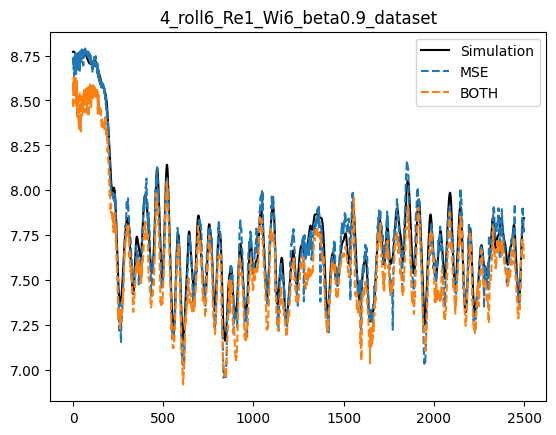

In [29]:

plt.plot(energy_X_train[-2500:],'k', label = 'Simulation')
for k, e in zip(labels, energies):
    plt.plot(e[-2500:],'--', label = k)
    
plt.legend()
plt.title(simulation_name)
print(f'Loss:\tEnergy \t\t MSE')
for k, e, m in zip(labels, err_energy, mses):
    print(f'{k}:\t{e:.3g}\t\t {m:.3g}')

Loss:	Energy 		 MSE
MSE:	0.0969		 0.396
BOTH:	0.0771		 0.387


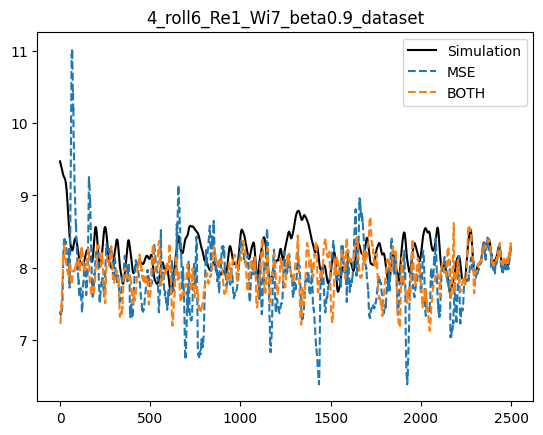

In [42]:

plt.plot(energy_X_train[-2500:],'k', label = 'Simulation')
for k, e in zip(labels, energies):
    plt.plot(e[-2500:],'--', label = k)
    
plt.legend()
plt.title(simulation_name)
print(f'Loss:\tEnergy \t\t MSE')
for k, e, m in zip(labels, err_energy, mses):
    print(f'{k}:\t{e:.3g}\t\t {m:.3g}')

Loss:	Energy Err	 MSE
MSE:	0.0179		 0.312
BOTH:	0.00736		 0.0662


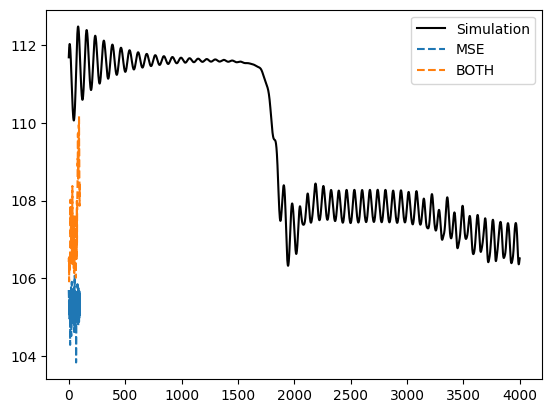

In [28]:
energies = []
mses = []
err_energy = []
norm_mse = np.linalg.norm(X_test)
sum_energy = energy_X_test.sum()
for ae in [ae_mse, ae_both]:
    X_rec,_,_ = ae(X_test_torch.to(device))
    X_rec = torch2np(X_rec)
    # 4- Calc error
    _, _, energy_rec = calc_energy(X_rec,Wi,beta, Re, dx, dy)
    energies.append(energy_rec)
    mses.append(np.linalg.norm(X_test - X_rec.T) / norm_mse)
    err_energy.append(np.abs(energy_X_test - energy_rec).sum()/ sum_energy)


plt.plot(energy_X_train,'k', label = 'Simulation')

for k, e in zip(labels, energies):
    plt.plot(e,'--', label = k)
    
plt.legend()
print(f'Loss:\tEnergy Err\t MSE')
for k, e, m in zip(labels, err_energy, mses):
    print(f'{k}:\t{e:.3g}\t\t {m:.3g}')

In [46]:
X.shape, 128**2 * 5

((3496, 81920), 81920)

In [1]:
selected_file = files[1]
dx1 = dy1 = (2*np.pi)/2**7
dx2 = dy2 = (2*np.pi)/2**6
for selected_file in files:
    simulation_name  = ".".join(selected_file.split('.')[:-1])
    grid_type = simulation_name.split('_')[1]
    if grid_type == 'roll6':
        dx = dy = dx2
    elif grid_type == 'roll7vtk':
        dx = dy = dx1
        continue
    else:
        print('erro - ', simulation_name)
    print(simulation_name)
    X, sqrt_theta, param = get_matrix(selected_file, 0)

    X_train = X[200:3000]
    X_test = X[-100:]

    Re = param[0]
    Wi = param[1]
    beta = param[2]
    theta_mult = sqrt_theta @ sqrt_theta.T
    theta = np.diag(theta_mult)[:,None]
    _, _, energy_X_train = calc_energy(X_train.T,Wi,beta, Re, dx, dy)
    plt.figure()
    plt.plot(energy_X_train,'k', label = 'Simulation')
    plt.title(simulation_name)

NameError: name 'files' is not defined

# Novo Teste
    -  Reconstrução Não linear do Kernel para analisar os shift